In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# Merge all data collected from 2013 - 2022
path = r'../data/curated/merged_dataset/'
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in sorted(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

merged_df = pd.concat(li, axis=0, ignore_index=True)
merged_df.drop(['address', 'latitude', 'longitude', 'postcode', 'sa2_2016'], axis=1, inplace=True)

# Check the merged dataframe
merged_df

Index(['year', 'sa2_2021', 'residence_type', 'nbed', 'nbath', 'ncar',
       'min_distance_to_cbd', 'min_distance_to_park', 'min_distance_to_prim',
       'min_distance_to_second', 'min_distance_to_train',
       'min_distance_to_hosp', 'min_distance_to_poli', 'min_distance_to_shop',
       'weekly_rent', 'gdp(USD Millioins)', 'saving_rate(% of GDP)',
       'income_per_person', 'population_density', 'crime_cases'],
      dtype='object')


year   sa2_2021 residence_type  nbed  nbath  ncar  \
0       2013  204011057          House   2.0    1.0     0   
1       2013  205051101          House   2.0    1.0     0   
2       2013  204011057          House   2.0    1.0     0   
3       2013  202011022          House   4.0    2.0     0   
4       2013  208041195      Apartment   1.0    1.0     0   
...      ...        ...            ...   ...    ...   ...   
172030  2022  205021086          House   3.0    1.0     1   
172031  2022  217041479          House   3.0    2.0     2   
172032  2022  208021177          House   2.0    2.0     1   
172033  2022  206041506      Apartment   1.0    1.0     1   
172034  2022  206071139      Apartment   1.0    1.0     1   

        min_distance_to_cbd  min_distance_to_park  min_distance_to_prim  \
0                 227.97163              23.16035               7.35747   
1                 223.66084               5.71742               6.50536   
2                 243.25680               5.11222               0.20027   
3                 140.35827              78.32509              10.66523   
4                  13.86135               0.93250               1.32931   
...                     ...                   ...                   ...   
172030            293.28053               0.56012               1.21809   
172031            258.29111               3.49087               5.08707   
172032              9.47077               2.45011               1.33931   
172033              1.84933               0.65199               1.10438   
172034              4.58626               0.48042               0.49588   

        min_distance_to_second  min_distance_to_train  min_distance_to_hosp  \
0                     16.96507               35.56825              21.35025   
1                      6.76794                7.54355               7.42972   
2                     36.72106               50.85341              36.63541   
3                     11.91899               11.26906             177.44731   
4                      3.49174                2.20800             177.44731   
...                        ...                    ...                   ...   
172030               114.77016               90.08591             140.56888   
172031                 3.60570                8.37185               2.60312   
172032                 1.62322                3.63291             140.56888   
172033                 1.27940                1.87840             140.56888   
172034                 1.47456                1.29233             140.56888   

        min_distance_to_poli  min_distance_to_shop  weekly_rent  \
0                   22.04660               9.35209        300.0   
1                    6.28177               9.35209        215.0   
2                    0.08478               9.35209        175.0   
3                   84.47341               9.35209        350.0   
4                   84.47341               3.96501        275.0   
...                      ...                   ...          ...   
172030              74.35608              13.64920        265.0   
172031              74.35608              13.64920        500.0   
172032              74.35608               1.97636        750.0   
172033              74.35608              13.64920        409.0   
172034               1.38884              13.64920        365.0   

        gdp(USD Millioins)  saving_rate(% of GDP)  income_per_person  \
0                  1536454               6.861393       39683.563449   
1                  1536454               6.861393       47222.702327   
2                  1536454               6.861393       39683.563449   
3                  1536454               6.861393       43556.283562   
4                  1536454               6.861393       86103.411528   
...                    ...                    ...                ...   
172030             3305754              12.839000       54365.266130   
172031             3305754              12.8

In [7]:
# Convert the numbers read as string to floats and integers
for col in merged_df.columns:
    if col not in ['residence_type', 'year']:
        merged_df[col] = merged_df[col].astype(float)
merged_df['year'] = merged_df['year'].astype(int)

# Rename the columns to facilitate to call them for later
merged_df.rename({'gdp(USD Millioins)': 'gdp', 'saving_rate(% of GDP)': 'saving_rate'}, axis=1, inplace=True)

# In order to put them into the regressor, make the categorical data to numeric
merged_df['residence_type'] = merged_df['residence_type'].astype('category')
merged_df['residence_type'] = merged_df['residence_type'].cat.codes

# Drop Nans
merged_df.dropna(inplace=True)

# Log transformatoin on our target class for better performance 
y = np.log(merged_df['weekly_rent'])

# Assign predictor data to X for training purposes
merged_df.drop('weekly_rent', axis=1, inplace=True)
X = merged_df

print(y)
print(X.dtypes)


0         5.703782
1         5.370638
2         5.164786
3         5.857933
4         5.616771
            ...   
172030    5.579730
172031    6.214608
172032    6.620073
172033    6.013715
172034    5.899897
Name: weekly_rent, Length: 172018, dtype: float64
year                        int64
sa2_2021                  float64
residence_type               int8
nbed                      float64
nbath                     float64
ncar                      float64
min_distance_to_cbd       float64
min_distance_to_park      float64
min_distance_to_prim      float64
min_distance_to_second    float64
min_distance_to_train     float64
min_distance_to_hosp      float64
min_distance_to_poli      float64
min_distance_to_shop      float64
gdp                       float64
saving_rate               float64
income_per_person         float64
population_density        float64
crime_cases               float64
dtype: object


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state= 42)

# Train the model with the training dataset
sel = RandomForestRegressor(n_estimators = 100)
sel.fit(X_train, y_train)

# Get the names of features selected
sel.feature_importances_

array([0.01378476, 0.02791134, 0.00625137, 0.09025192, 0.1534936 ,
       0.01894832, 0.11865757, 0.0437883 , 0.04880001, 0.03651756,
       0.03048934, 0.01728595, 0.02515408, 0.01082397, 0.0137023 ,
       0.01074241, 0.25555463, 0.04895234, 0.02889022])

{'year': 0.013784758202212243, 'sa2_2021': 0.027911344149956455, 'residence_type': 0.006251369352520878, 'nbed': 0.09025192236255856, 'nbath': 0.15349360074633703, 'ncar': 0.018948315109758983, 'min_distance_to_cbd': 0.11865756614256869, 'min_distance_to_park': 0.04378830352267234, 'min_distance_to_prim': 0.04880001421043043, 'min_distance_to_second': 0.036517561120363924, 'min_distance_to_train': 0.03048933531081797, 'min_distance_to_hosp': 0.01728595096491652, 'min_distance_to_poli': 0.02515408438658827, 'min_distance_to_shop': 0.010823973326300492, 'gdp': 0.013702303320013149, 'saving_rate': 0.01074241135630722, 'income_per_person': 0.25555462637681414, 'population_density': 0.048952339219612735, 'crime_cases': 0.02889022081925022}
[('residence_type', 0.006251369352520878), ('saving_rate', 0.01074241135630722), ('min_distance_to_shop', 0.010823973326300492), ('gdp', 0.013702303320013149), ('year', 0.013784758202212243), ('min_distance_to_hosp', 0.01728595096491652), ('ncar', 0.01894

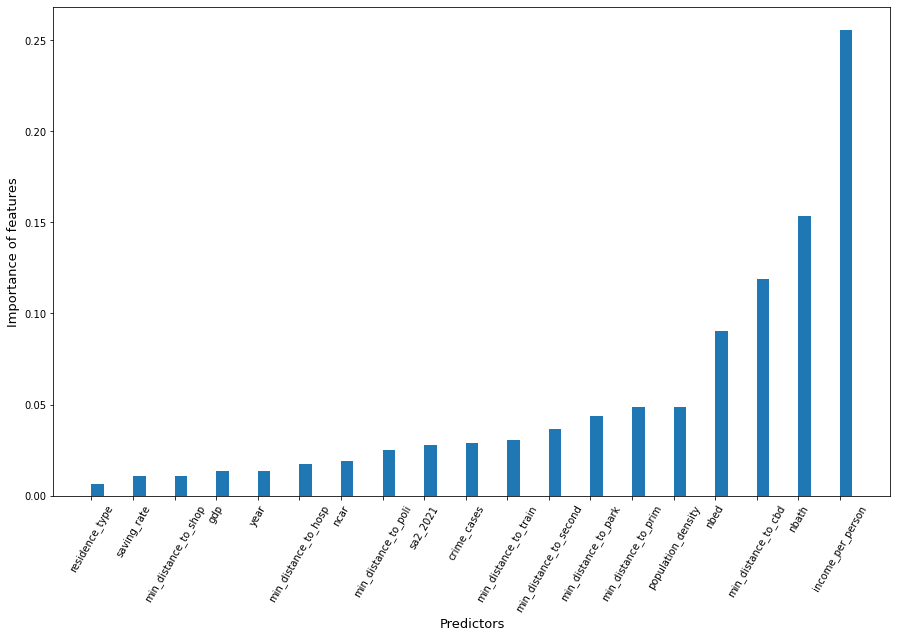

In [9]:
# Make a dictionary with the feature importances calculated from the above cell 
dict = {}

for i in range(len(X.columns)):
    dict[X.columns[i]] = sel.feature_importances_[i]

# Sort the dictinary keys by the values (feature importance values)
sorted_dict = sorted(dict.items(), key=lambda x:x[1])

# Extract information to visualize the features with their importance values
keys = []
vals = []
for i in sorted_dict:
    keys.append(i[0])
    vals.append(i[1])

print(keys, vals)

plt.figure(figsize=(15, 9)) 
plt.bar(keys, vals, align='edge', width=0.3)
plt.xticks(rotation=60)
plt.ylabel("Importance of features", fontsize = 13)
plt.xlabel("Predictors", fontsize = 13)
plt.show()

As found above, the most important feature is 'income per person' and the least important feature is residence_type according to the random forest regressor. The values of how important / significant features are computed with the mean and standard deviation of accumulation of the impurity decrease (which means to have stronger sign to predict the target class, weekly_rent) within each tree. </br>
It is interesting that the residence type was not ranked in a higher positino in the feature importance. Since most of our rental property data are categorized under 'house', this may have caused the lowest importance value because under 'house' it has a big range of rental prices. This is a possible limitation about our raw data since we categorized all different kinds of house such as villa or townhouse under 'house' from our team's assumption that customers might want simpler choices given (which are house vs apartment) when they select the property they prefer when using our website. </br>
The other interesitng finding is the predictors do not really seem to have huge contributions. It may indicate that our attributes may not direct factors to predict weekly_rent. Otherwise, it might be caused from our data collection method since the data for each predictor was not able to get collected from one source, hence they are coming from all difference resources and also were labelled with different area granualrities (SA2_2016, SA2_2021, postcodes etc).

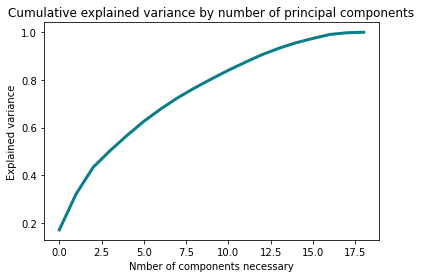

In [10]:
# Scrutinize the data with PCA: Test the attribute relevance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components')
plt.xlabel("Nmber of components necessary")
plt.ylabel("Explained variance")
plt.show()

Since the predictors all have feature importances lower than 30%, it was hard to choose what features to drop from the input dataset of our prediction model. Therefore, PCA feature selection was also implemented to see how many predictors we need to put into our final model to predict the weekly_rent price. Not surprisingly, the result showed when we have all features, we can have the maximum explained variance. We could have dropped some of the features where the explained variance reaches around 80%, but since all of our predictors are not strong enough to predict weekly rental prices, we put them all hoping that they will still support each other to make a clearer prediction. 

In [11]:
# Check the accuracy before predicting with the trained random forest regressor
r2 = sel.score(X_test, y_test)
print('Testing R2:', round(r2, 2)*100, '%.')

Testing R2: 73.0 %.


In [12]:
# Training accruacy
r2 = sel.score(X_train, y_train)
print('Training R2:', round(r2, 2)*100, '%.')

Training R2: 96.0 %.


The computed training R squared is around 96% while the testing is approximately 73%. This is qute reasonable results because the training one is predicting the weekly rent from the dataset that they have been trained on. 